In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

## **Preparing data**

In [184]:
# Read in data
df = pd.read_csv('/kaggle/input/flipkart-reviews-2024/flipkart.csv')
print(df.shape)
df = df.head(10)
print(df.shape)

(2304, 4)
(10, 4)


In [185]:
df.columns = ['Id', 'Product_name', 'Review', 'Rating']

In [186]:
df.head()

,Id,Product_name,Review,Rating
0,0,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Best under 60k Great performanceI got it for a...,5
1,1,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Good perfomence...,5
2,2,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Great performance but usually it has also that...,5
3,3,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,My wife is so happy and best product 👌🏻😘,5
4,4,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,"Light weight laptop with new amazing features,...",5


In [187]:
df['Review'].values[0]

'Best under 60k Great performanceI got it for around 58500Battery backup is bit low but thanks to rapid charger its very fast Display is Ok for this price range Decent speakers with many customisation optionsVantage software is so good for customisationOverall good performance till nowWill update later if any problem occurs'

## **EDA**

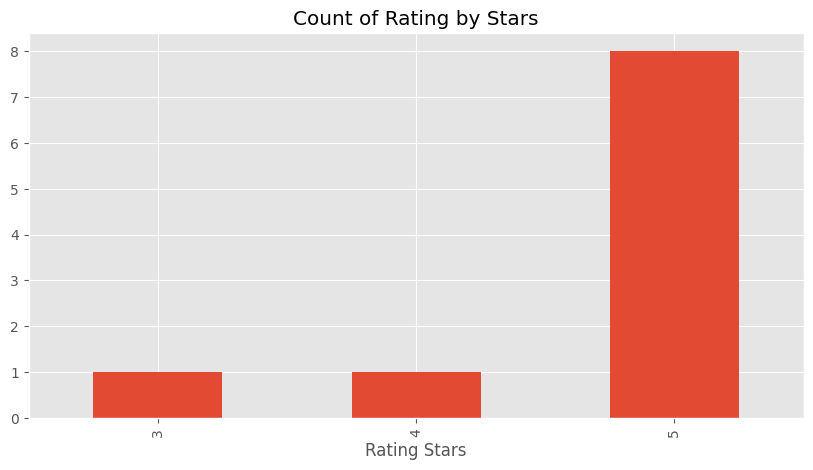

In [188]:
ax = df['Rating'].value_counts().sort_index().plot(kind='bar', title='Count of Rating by Stars', figsize=(10, 5))
ax.set_xlabel('Rating Stars')
plt.show()

## **Basic NLTK**

In [189]:
example = df['Review'][9]
print(example)

Good for normal work , students, online classes, watching movies etc.Not for havy tasks, gaming, buisness work, office work.editing etc.Overall good laptop in this range in budget laptops.


In [190]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Good',
 'for',
 'normal',
 'work',
 ',',
 'students',
 ',',
 'online',
 'classes',
 ',']

In [191]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Good', 'JJ'),
 ('for', 'IN'),
 ('normal', 'JJ'),
 ('work', 'NN'),
 (',', ','),
 ('students', 'NNS'),
 (',', ','),
 ('online', 'NN'),
 ('classes', 'NNS'),
 (',', ',')]

In [192]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Good/JJ)
  for/IN
  normal/JJ
  work/NN
  ,/,
  students/NNS
  ,/,
  online/NN
  classes/NNS
  ,/,
  watching/VBG
  movies/NNS
  etc.Not/VBP
  for/IN
  havy/JJ
  tasks/NNS
  ,/,
  gaming/VBG
  ,/,
  buisness/NN
  work/NN
  ,/,
  office/NN
  work.editing/VBG
  etc.Overall/RB
  good/JJ
  laptop/NN
  in/IN
  this/DT
  range/NN
  in/IN
  budget/NN
  laptops/NNS
  ./.)


## **VADER Sentiment Scoring**

In [193]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

In [ ]:
sia.polarity_scores('This is the worst thing ever')

In [ ]:
example

In [ ]:
sia.polarity_scores(example)

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    review = row['Review']
    myid = row['Id']
    res[id] = sia.polarity_scores(review)
    break
print()

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.head()

In [ ]:
# Plot VADER results
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound Rating by Star Review')
plt.show()

In [ ]:
fig, axs =plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[0].set_title('Neutral')
axs[0].set_title('Negative')
plt.tight_layout()
plt.show()

## **Roberta Pretrained Model**

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
# Import a pretrained model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
# Adding a 'try' function to skip data that is too big for the model
    try:
        review = row['Review']
        myid = row['Id']
        vader_result = sia.polarity_scores(review)
# Rename from neg, pos to Vader results     
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(review)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
    break

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## **Compare Ratings between models**

In [ ]:
results_df.columns

In [ ]:
sns.pairplot(data=results_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show()

In [ ]:
results_df.head()

## **Review Examples**

In [ ]:
# Do this to see where the model scoring and review score differ the most
results_df.query('Rating == 1')\
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

In [ ]:
results_df.query('Rating == 1')\
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

In [ ]:
# Negative sentiment 5-Star view
results_df.query('Rating == 5')\
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

In [ ]:
results_df.query('Rating == 5')\
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

## **Using The Transformers Pipeline**

In [ ]:
# This makes it easier to predict results using hugging face 
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('Thank God its Friday')

In [ ]:
sent_pipeline('Calm weather today')

In [ ]:
sent_pipeline('I do not like June')